In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

# Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

df.head(5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [6]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[(df.dtypes != 'object') & (df.columns != 'converted')].index)

In [7]:
categorical_columns, numerical_columns

(['lead_source', 'industry', 'employment_status', 'location'],
 ['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score'])

In [8]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [9]:
for c in categorical_columns:
    df.loc[:,c] = df[c].fillna('NA')

for c in numerical_columns:
    df.loc[:,c] = df[c].fillna(0.0)

df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [27]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train['converted'].to_numpy()
y_val = df_val['converted'].to_numpy()
y_test = df_test['converted'].to_numpy()

del df_train['converted']
del df_val['converted']
del df_test['converted']

# Q1

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [12]:
from sklearn.metrics import roc_auc_score

auc_values = {}

for v in numerical_columns:
    auc = roc_auc_score(y_train, df_train[v])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[v])

    auc_values[v]=auc

auc_values

{'number_of_courses_viewed': 0.7635680590007088,
 'annual_income': 0.5519578313253012,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176}

# Q2

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [28]:
df_train

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score
462,events,manufacturing,2,95543.0,unemployed,europe,3,0.78
135,referral,NA,1,54924.0,student,south_america,6,0.39
117,organic_search,healthcare,2,77352.0,unemployed,europe,2,0.22
1051,paid_ads,other,2,34600.0,employed,south_america,2,0.31
945,paid_ads,education,0,43615.0,unemployed,south_america,2,0.01
...,...,...,...,...,...,...,...,...
39,NA,other,5,67314.0,NA,europe,2,0.87
1261,events,education,6,63996.0,NA,australia,4,0.92
595,organic_search,finance,1,73702.0,unemployed,north_america,2,0.55
1329,events,technology,1,93341.0,student,middle_east,4,0.99


In [29]:
 df_train[categorical_columns + numerical_columns]

,lead_source,industry,employment_status,location,number_of_courses_viewed,annual_income,interaction_count,lead_score
462,events,manufacturing,unemployed,europe,2,95543.0,3,0.78
135,referral,NA,student,south_america,1,54924.0,6,0.39
117,organic_search,healthcare,unemployed,europe,2,77352.0,2,0.22
1051,paid_ads,other,employed,south_america,2,34600.0,2,0.31
945,paid_ads,education,unemployed,south_america,0,43615.0,2,0.01
...,...,...,...,...,...,...,...,...
39,NA,other,NA,europe,5,67314.0,2,0.87
1261,events,education,NA,australia,6,63996.0,4,0.92
595,organic_search,finance,unemployed,north_america,1,73702.0,2,0.55
1329,events,technology,student,middle_east,1,93341.0,4,0.99


In [34]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [35]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred_val = model.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, y_pred_val),3)

0.817

In [15]:
y_pred_val, y_val

(array([0.57539503, 0.47060768, 0.61901236, 0.6143892 , 0.61741031,
        0.67496748, 0.8465351 , 0.38205015, 0.55735358, 0.91246751,
        0.77549359, 0.66110422, 0.91574386, 0.38389183, 0.88197523,
        0.89511778, 0.65336369, 0.53077648, 0.73106703, 0.70418456,
        0.78080321, 0.51381844, 0.88869813, 0.72195815, 0.91633086,
        0.53483932, 0.50123084, 0.84175873, 0.48497478, 0.60635462,
        0.63002389, 0.50197705, 0.54916064, 0.91861628, 0.6902664 ,
        0.65666092, 0.84766044, 0.79947504, 0.47461069, 0.63286015,
        0.82887379, 0.4355907 , 0.45453631, 0.58816791, 0.64477414,
        0.73619001, 0.53893926, 0.71596382, 0.74170518, 0.86747808,
        0.77685777, 0.75943833, 0.84663023, 0.67334212, 0.78059001,
        0.68835976, 0.63561826, 0.56955796, 0.6699862 , 0.75372267,
        0.33388224, 0.6815564 , 0.35336532, 0.7745121 , 0.51403962,
        0.2620089 , 0.66844162, 0.41567479, 0.49375719, 0.54251895,
        0.85677057, 0.39794252, 0.46701359, 0.85

# Q3

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

/var/folders/p8/xm1_mmt52534xk0_68g3qwrw0000gn/T/ipykernel_15483/4077645607.py:19: RuntimeWarning: invalid value encountered in scalar divide
  precisions.append(tp/(tp+fp))


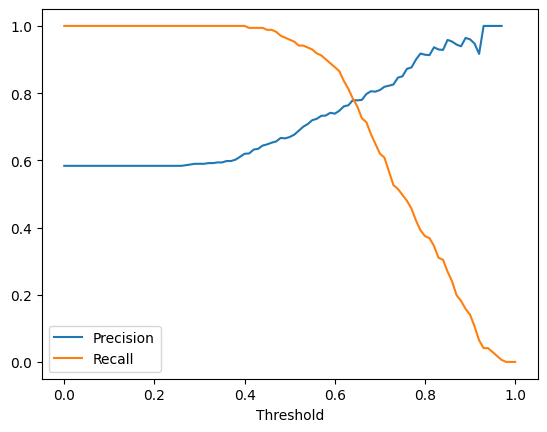

array([0.64])

In [16]:
thresholds = np.linspace(0,1, 101)

precisions = []
recalls = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred_val >= t)
    predict_negative = (y_pred_val < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precisions.append(tp/(tp+fp))
    recalls.append(tp/(tp+fn))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.show()

thresholds[np.where(np.abs(np.array(precisions)-np.array(recalls)) < 0.01)]

# Q4

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

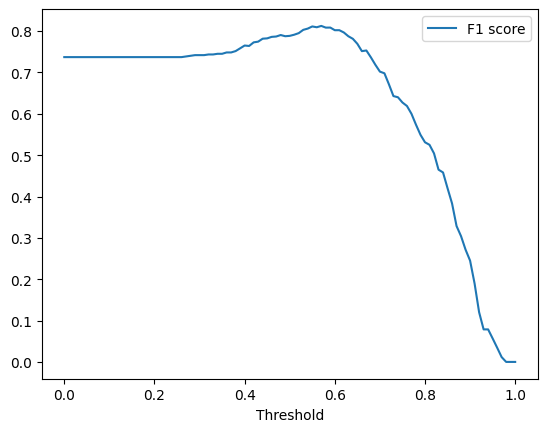

np.float64(0.5700000000000001)

In [17]:
thresholds = np.linspace(0,1, 101)

f1_scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred_val >= t)
    predict_negative = (y_pred_val < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp/(tp+fp) if (tp+fp)>0 else 0
    recall = tp/(tp+fn) if (tp+fn)>0 else 0

    f1_score = 2*precision*recall/(precision+recall) if precision + recall>0 else 0
    
    f1_scores.append(f1_score)

plt.plot(thresholds, f1_scores, label='F1 score')
plt.xlabel("Threshold")
plt.legend()
plt.show()

thresholds[np.argmax(np.array(f1_scores))]

# Q5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [18]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [20]:
from sklearn.model_selection import KFold

n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['converted'].to_numpy()
    y_val = df_val['converted'].to_numpy()

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

round(np.std(scores),3)

np.float64(0.036)

# Q6

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

In [22]:
n_splits = 5



for c in [0.000001, 0.001, 1]:

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['converted'].to_numpy()
        y_val = df_val['converted'].to_numpy()


        dv, model = train(df_train, y_train, C=c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f"C: {c}, mean: {round(np.mean(np.asarray(scores)), 3)}")


C: 1e-06, mean: 0.56
C: 0.001, mean: 0.867
C: 1, mean: 0.822
